In [ ]:
# Suppress warnings (including in worker processes started via spawn)
import os
# Ensure child processes inherit this setting
os.environ['PYTHONWARNINGS'] = 'ignore'

import warnings
warnings.filterwarnings("ignore")

___
# Patient populations across sites

### Imports

In [ ]:
import pandas as pd

# Project imports
from self_harm_triage_notes.config import *

### Summary statistics

In [ ]:
# Load data
data_filename = "rmh_2012_2022" # rmh_2012_2022, lvrh_2012_2022
site = "RMH"
df = pd.read_parquet(interim_data_dir / (data_filename + "_cleaned.parquet"), engine="pyarrow")

# Remove data from 2022
df = df[df.year < 2022].copy()

df

In [ ]:
def print_summary_statistics(df):
    print("Summary statistics:")

    print("Number of presentations per year:")
    print(df.year.value_counts().agg(['mean', 'std']).round().astype(int))

    print("Age at presentation:")
    print(df.age.describe().round().astype(int))

    print("Patient sex:")
    print(df.sex.value_counts(normalize=True).round(2)*100)

    print("Arrival method:")
    print(df.arrival_mode.value_counts(normalize=True).round(3)*100)

In [ ]:
print_summary_statistics(df)

___
# Proportions of SH and SI

### Imports

In [ ]:
import numpy as np
import pandas as pd

# Project imports
from self_harm_triage_notes.config import *
from self_harm_triage_notes.viz_utils import plot_presentations_over_time

# Toolbox imports
from ml_health_toolbox.dataset_utils import get_categorical_dtype, make_categorical


### Create barplots with numbers of presentations and proportion of positives

In [ ]:
# Load data
data_filename = "lvrh_2012_2022" # rmh_2012_2022, lvrh_2012_2022
site = "LRH"
df = pd.read_parquet(interim_data_dir / (data_filename + "_cleaned.parquet"), engine="pyarrow")

# Remove data from 2022
df = df[df.year < 2022].copy()

# Convert quarter to categorical
categorical_dtype, _ = get_categorical_dtype(df.quarter.unique(), ordered=True)
df.quarter = make_categorical(df.quarter, categorical_dtype)

# Palette
palette = ['#C5D1E0', '#E1A549', '#E15644']


In [ ]:
(df.SI.value_counts(dropna=False, normalize=True) * 100).round(1)

In [ ]:
(df.SH.value_counts(dropna=False, normalize=True) * 100).round(1)

In [ ]:
plot_presentations_over_time(df, site, palette=palette, annotate_dev=False, results_dir=results_dir)

___
# Length of triage notes

### Imports

In [ ]:
import pandas as pd

# Project imports
from self_harm_triage_notes.config import *
from self_harm_triage_notes.viz_utils import plot_length_over_time

# Toolbox imports
from ml_health_toolbox.dataset_utils import get_categorical_dtype, make_categorical

### Summary statistics

In [ ]:
# Load data
data_filename = "lvrh_2012_2022" # rmh_2012_2022, lvrh_2012_2022
site = "LRH"
df = pd.read_parquet(interim_data_dir / (data_filename + "_cleaned.parquet"), engine="pyarrow")

# Remove data from 2022
df = df[df.year < 2022].copy()

# Convert quarter to categorical
categorical_dtype, _ = get_categorical_dtype(df.quarter.unique(), ordered=True)
df.quarter = make_categorical(df.quarter, categorical_dtype)

# Palette
palette = ['#757F8D', '#E15644']

In [ ]:
df.length.describe()

In [ ]:
plot_length_over_time(df, site, palette=palette, annotate_dev=False, results_dir=results_dir)

___
# Model evaluation

### Imports

In [ ]:
import numpy as np
import pandas as pd

import pickle

# Project imports
from self_harm_triage_notes.config import *
# from self_harm_triage_notes.text_utils import *
from self_harm_triage_notes.viz_utils import plot_probabilities, plot_score_over_time, plot_confusion_matrix_all_labels

# Toolbox imports
from ml_health_toolbox.dataset_utils import get_categorical_dtype, make_categorical
from ml_health_toolbox.eval_utils import (
    calculate_roc_curve_coords, calculate_pr_curve_coords, 
    calculate_precision_score, calculate_recall_score, 
    make_predictions, 
    prepare_calibration_curve, plot_calibration_curve,
    calculate_curve_coords, calculate_auc_from_coords, calculate_stats,
    plot_roc_curve, plot_pr_curve,
    calculate_classification_metrics,
    plot_confusion_matrix
)

# Pandas settings
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100

### Set-up

In [ ]:
# Classification label and features
label = 'SH'
features = 'entities'

classification_metrics = [
        {
        'name': 'precision', 
        'func': calculate_precision_score,
        },
        {
        'name': 'recall', 
        'func': calculate_recall_score,
        },
    ]

palette_for_scores = {
    'PR AUC': "#AE337B", #'mediumpurple', 
    'PPV': "#3B5E9A", #'dodgerblue', 
    'Sensitivity': "#2C7A76", #'forestgreen', 
    'Specificity': "#ABA225", #'darkorange'
}

palette_for_two_classes = ['#757F8D', '#E8471B']


### Load the model

In [ ]:
# Development data
dev_data_filename = "rmh_2012_2017_dev"

# Classifier and threshold
model_filename = dev_data_filename + "_SH_REFIT_ensemble_True" # "_SH_REFIT_uncalibrated" "_SH_REFIT_ensemble_True"

# Load the pre-trained model and threshold
with open(models_dir / (model_filename + "_classifier.pickle"), 'rb') as f:
    model = pickle.load(f)
with open(models_dir / (model_filename + "_threshold.txt"), 'r') as f:
    threshold = float(f.read())

### Load the development dataset

In [ ]:
# Load the development set
df_dev = pd.read_parquet(proc_data_dir / (dev_data_filename + "_normalised.parquet"), engine="pyarrow")

# Keep data up to 2017 for development
df_dev = df_dev[df_dev.year <= 2017].copy()

# Rename label column
df_dev.rename(columns={label: 'y'}, inplace=True)

# Class names
classes = df_dev.y.cat.categories

## Validation

### Load data

In [ ]:
# Test data
test_data_filename = "rmh_2018_2022" # rmh_2012_2017_test rmh_2018_2022 lvrh_2012_2022
dataset_name = "Prospective" # Test Prospective External
title = "Prospective validation" # Internal Prospective External
cut_off_year = 2022 # 2017 2022

# Load the test set
df = pd.read_parquet(proc_data_dir / (test_data_filename + "_normalised.parquet"), engine="pyarrow")

# Keep data up to 2017 for evaluation
df = df[df.year <= cut_off_year].copy()

# Create single label for all annotations
df['all_labels'] = 'Control'
df.loc[df.SH == 'Self-harm', 'all_labels'] = 'Self-harm'
df.loc[df.SI == 'Suicidal ideation', 'all_labels'] = 'Suicidal ideation'

# Convert to categorical
categorical_dtype, _ = get_categorical_dtype(['Control', 'Suicidal ideation', 'Self-harm'], ordered=False)
df['all_labels'] = make_categorical(df['all_labels'], categorical_dtype)

# Rename label column
df.rename(columns={label: 'y'}, inplace=True)

# Convert quarter to categorical
categorical_dtype, _ = get_categorical_dtype(df.quarter.unique(), ordered=True)
df.quarter = make_categorical(df.quarter, categorical_dtype)

### Make predictions

In [ ]:
df[classes], df['prediction'] = make_predictions(model, df[features], classes, threshold, normalize=True)

### Plot calibration curves (full dataset w/bootstrap)

In [ ]:
# Calculate calibration curves for the full dataset w/bootastrap
calibration_curves = prepare_calibration_curve(df.y, df[classes], generator=True)

# Plot calibration curves for the full dataset w/bootastrap
plot_calibration_curve(calibration_curves, palette=palette_for_two_classes[1:], results_dir=results_dir, filename=test_data_filename + " bootstrap")

### Calculate and plot discrimination metrics (full dataset w/bootstrap)

In [ ]:
# Define curves to calculate
curves_to_calculate = [
        {
        'name': 'ROC AUC', 
        'func': calculate_roc_curve_coords,
        'binary_filter': True,
        },
        {
        'name': 'PR AUC', 
        'func': calculate_pr_curve_coords,
        'binary_filter': False,
        },
    ]

# Calculate curve coordinates for the full dataset w/bootstrap
curve_coords = calculate_curve_coords(df.y, df[classes], curves_to_calculate, generator=True)

In [ ]:
# Calculate discrimination metrics per class
calculate_stats(calculate_auc_from_coords(curve_coords), return_ci=True).round(2)

In [ ]:
# Calculate macro-averaged discrimination metrics
calculate_stats(calculate_auc_from_coords(curve_coords), macro_average=True ,return_ci=True)

In [ ]:
# Plot ROC curves
plot_roc_curve(curve_coords[curve_coords.metric == 'ROC AUC'], return_ci=True, palette=palette_for_two_classes[1:], results_dir=results_dir, filename=test_data_filename + " bootstrap")
# Plot ROC curves
plot_pr_curve(curve_coords[curve_coords.metric == 'PR AUC'], return_ci=True, palette=palette_for_two_classes, results_dir=results_dir, filename=test_data_filename + " bootstrap")

### Calculate classification metrics (full dataset w/bootstrap)

In [ ]:
# Calculate overall classification metrics
calculate_stats(calculate_classification_metrics(df.y, df.prediction, classification_metrics, generator=True), return_ci=True).round(2)

### Plot probability distribution

In [ ]:
plot_probabilities(df.y, df[classes], palette_for_two_classes, threshold=threshold, results_dir=results_dir, filename=test_data_filename)

### Plot a confusion matrix

In [ ]:
print("Total number of presentations:", len(df))
print("Proportion of self-harm presentations:", (df.y == 'Self-harm').mean().round(3)*100, "%")
print("Proportion predicted as self-harm:", (df.prediction == 'Self-harm').mean().round(3)*100, "%")
print("Proportion of suicidal ideation predicted as self-harm:", 
      (((df.all_labels == 'Suicidal ideation') & (df.prediction == 'Self-harm')).sum() / ((df.y == 'Not self-harm') & (df.prediction == 'Self-harm')).sum()).round(3)*100, "%")

In [ ]:
plot_confusion_matrix(df.y, df.prediction, color=palette_for_two_classes[0], results_dir=results_dir, filename=test_data_filename)

In [ ]:
plot_confusion_matrix_all_labels(df.all_labels, df.prediction, color=palette_for_two_classes[0], results_dir=results_dir, filename=test_data_filename)

### Calculate and plot discrimination metrics (per quarter w/bootstrap)

In [ ]:
# Define curves to calculate
curves_to_calculate = [
        {
        'name': 'PR AUC', 
        'func': calculate_pr_curve_coords,
        'binary_filter': True,
        },
    ]
# Calculate discrimination metrics on the full dataset
scores_overall = calculate_auc_from_coords(calculate_curve_coords(df.y, df[classes], curves_to_calculate))
# Calculate discrimination metrics per quarter w/bootstrap
scores_per_quarter = df.groupby('quarter').apply(lambda x: calculate_auc_from_coords(calculate_curve_coords(x.y, x[classes], curves_to_calculate, generator=True))).reset_index('quarter')

In [ ]:
# PR AUC over time plot
plot_score_over_time(
    scores_overall[(scores_overall.class_ == 'Self-harm') & (scores_overall.metric == 'PR AUC')], 
    scores_per_quarter[(scores_per_quarter.class_ == 'Self-harm') & (scores_per_quarter.metric == 'PR AUC')],
    palette=palette_for_scores, dataset_name=dataset_name, score_name="PR AUC", title=title,
    estimated_overall=0.84, results_dir=results_dir)

### Calculate and plot classification metrics (per quarter w/bootstrap)

In [ ]:
# Calculate classification metrics on the full dataset
scores_overall = calculate_classification_metrics(df.y, df.prediction, classification_metrics)
# Calculate classification metrics per quarter w/bootstrap
scores_per_quarter = df.groupby('quarter').apply(lambda x: calculate_classification_metrics(x.y, x.prediction, classification_metrics, generator=True)).reset_index('quarter')

In [ ]:
# PPV over time plot
plot_score_over_time(
    scores_overall[(scores_overall.class_ == 'Self-harm') & (scores_overall.metric == 'precision')], 
    scores_per_quarter[(scores_per_quarter.class_ == 'Self-harm') & (scores_per_quarter.metric == 'precision')],
    palette=palette_for_scores, dataset_name=dataset_name, score_name="PPV", title=title,
    estimated_overall=0.79, results_dir=results_dir)

In [ ]:
# Sensitivity over time plot
plot_score_over_time(
    scores_overall[(scores_overall.class_ == 'Self-harm') & (scores_overall.metric == 'recall')], 
    scores_per_quarter[(scores_per_quarter.class_ == 'Self-harm') & (scores_per_quarter.metric == 'recall')],
    palette=palette_for_scores, dataset_name=dataset_name, score_name="Sensitivity", title=title,
    estimated_overall=0.79, results_dir=results_dir)

In [ ]:
# Specificity over time plot
plot_score_over_time(
    scores_overall[(scores_overall.class_ == 'Not self-harm') & (scores_overall.metric == 'recall')], 
    scores_per_quarter[(scores_per_quarter.class_ == 'Not self-harm') & (scores_per_quarter.metric == 'recall')],
    palette=palette_for_scores, dataset_name=dataset_name, score_name="Specificity", title=title,
    estimated_overall=1.0, results_dir=results_dir)

In [ ]:
# # df = pd.DataFrame({
# #     'quarter': ['2012Q1']*5+['2012Q2']*5+['2012Q3']*5+['2012Q4']*5,
# #     'fold': [0,1,2,3,4]*4,
# #     'score': [0.85, 0.67, 0.83, 0.88, 0.86, 0.84, 0.86, 0.82, 0.87, 0.94, 0.83, 0.85, 0.81, 0.86, 0.73, 0.82, 0.84, 0.80, 0.85, 0.83],
# #     'class_': ['Self-harm']*20
# #     })
# # df

# # df = pd.DataFrame({
# #     'quarter': ['2012Q1']*50+['2012Q2']*50+['2012Q3']*50+['2012Q4']*50,
# #     'fold': ([0]*10 + [1]*10 + [2]*10 + [3]*10 + [4]*10) * 4,
# #     'x1': [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]*20,
# #     'x2': [0.85, 0.84, 0.83, 0.8, 0.8, 0.79, 0.65, 0.44, 0.32, 0.21]*20,
# #     'class_': ['Self-harm']*200
# #     })
# # df

# classes = ["Not self-harm", "Self-harm"]

# df = pd.DataFrame({
#     'quarter': ['2012Q1']*2+['2012Q2']*5+['2012Q3']*3+['2012Q4']*4,
#     'y': ['Self-harm', 'Not self-harm', 'Self-harm', 'Self-harm', 'Self-harm', 'Not self-harm', 'Self-harm', 'Not self-harm', 'Not self-harm', 'Not self-harm', 'Self-harm', 'Not self-harm', 'Self-harm', 'Not self-harm'],
#     'Not self-harm': [0.7, 0.9, 0.2, 0.3, 0.4, 0.8, 0.15, 0.7, 0.2, 0.8, 0.25, 0.75, 0.35, 0.15],
#     'Self-harm': [0.3, 0.1, 0.8, 0.7, 0.6, 0.2, 0.85, 0.3, 0.8, 0.2, 0.75, 0.25, 0.65, 0.85],
#     })
# dtype,_ = get_categorical_dtype(df.quarter.unique(), ordered=True)
# df.quarter = make_categorical(df.quarter, dtype)

# dtype,_ = get_categorical_dtype(classes)
# df.y = make_categorical(df.y, dtype)
# df

___
# Effects of text normalisation

### Imports

In [1]:
import numpy as np
import pandas as pd

import pickle

# Project imports?
from self_harm_triage_notes.config import *
from self_harm_triage_notes.text_utils import *
from self_harm_triage_notes.viz_utils import (
    plot_dim_over_time, 
    plot_token_overlap_over_time,
    plot_dim_reduction_over_time,
    plot_selected_fts_over_time,
    plot_divergence_over_time,
)

# Toolbox imports
from ml_health_toolbox.dataset_utils import get_categorical_dtype, make_categorical

# Pandas settings
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100

### Set-up

In [2]:
# Classification label and features
label = 'SH'
features = 'entities'

palette = [
    "#AE337B", #'mediumpurple', 
    "#3B5E9A", #'dodgerblue', 
    "#2C7A76", #'forestgreen', 
    "#ABA225", #'darkorange'
    ]

### Load vocab and features

In [3]:
# ED vocabulary
vocab_filename = "rmh_2012_2017_dev_amt6"

# Load the ED vocabulary
vocab = load_vocab(spell_corr_dir, vocab_filename)

# Development data
dev_data_filename = "rmh_2012_2017_dev"

# Selected features
model_filename = dev_data_filename + "_SH_REFIT_ensemble_True"

# Load selected features
with open(models_dir / (model_filename + "_selected_fts_all.txt"), 'r') as f:
    selected_features = f.read().split('\n')
len(selected_features)


Domain-specific vocabulary contains 20043 words.


1931

### Load the development dataset

In [4]:
dataset_name = "Development" # Test Prospective External

# Load the development set
df_dev = pd.read_parquet(proc_data_dir / (dev_data_filename + "_normalised.parquet"), engine="pyarrow")

# Keep data up to 2017 for development
df_dev = df_dev[df_dev.year <= 2017].copy()

# Convert quarter to categorical
categorical_dtype, _ = get_categorical_dtype(df_dev.quarter.unique(), ordered=True)
df_dev.quarter = make_categorical(df_dev.quarter, categorical_dtype)

### Load data

In [11]:
# df = df_dev.copy()

# Test data
test_data_filename = "lvrh_2012_2022" # rmh_2012_2017_test rmh_2018_2022 lvrh_2012_2022
dataset_name = "External" # Test Prospective External
cut_off_year = 2022 # 2017 2022

# Load the test set
df = pd.read_parquet(proc_data_dir / (test_data_filename + "_normalised.parquet"), engine="pyarrow")

# Keep data up to 2017 for evaluation
df = df[df.year <= cut_off_year].copy()

# Convert quarter to categorical
categorical_dtype, _ = get_categorical_dtype(df.quarter.unique(), ordered=True)
df.quarter = make_categorical(df.quarter, categorical_dtype)

### Temporal changes

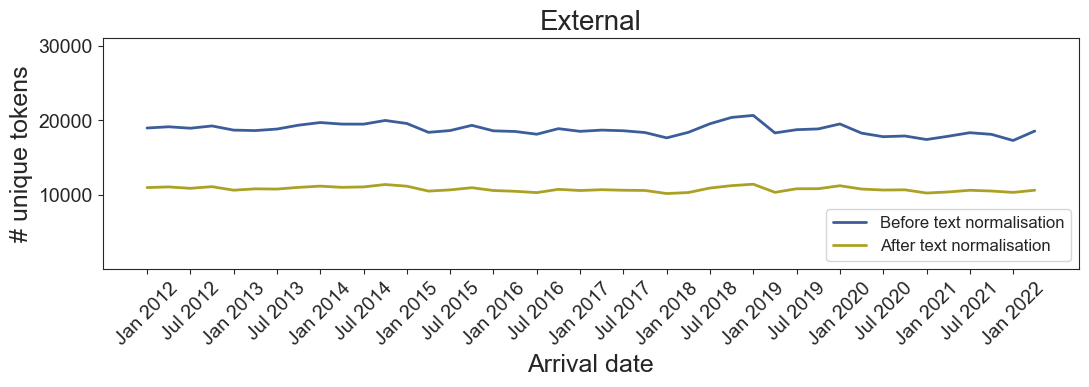

In [12]:
# 1 & 4. How many unique tokens were there 
# before and after text normalisation?
plot_dim_over_time(df, title=dataset_name, palette=palette, results_dir=results_dir)

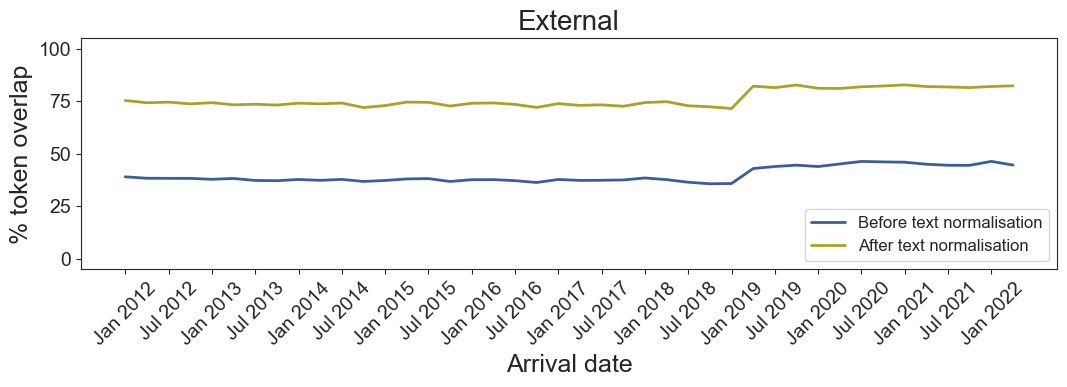

In [13]:
# 2 & 5. How similar were the notes to the normalised 
# development data before and after text normalisation?
plot_token_overlap_over_time(df, vocab, title=dataset_name, palette=palette, results_dir=results_dir)

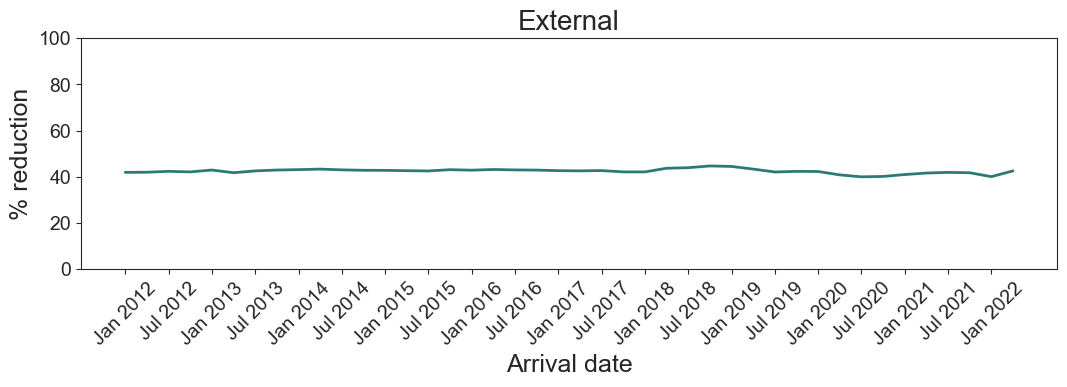

In [14]:
# 3. How effective was text normalisation 
# in dimensionality reduction? 
plot_dim_reduction_over_time(df, 'preprocessed_triage_note', 'entities', title=dataset_name, palette=palette, results_dir=results_dir)

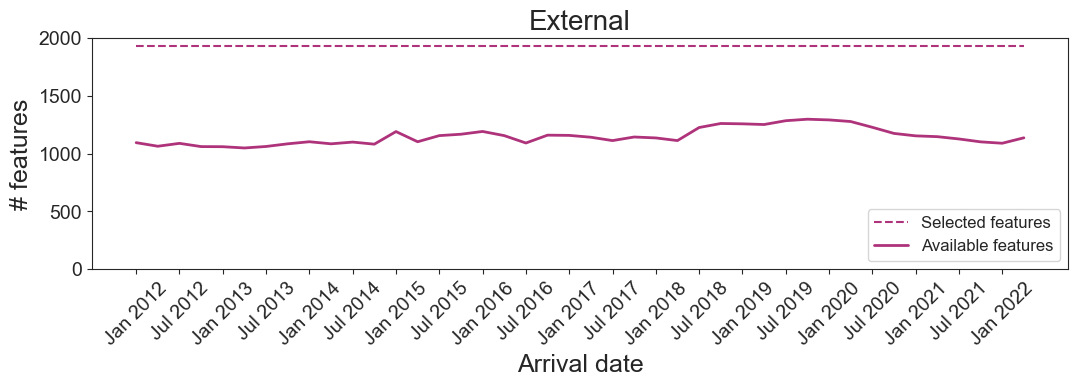

In [15]:
# 6. How many of the selected features were 
# present in the normalised notes?
plot_selected_fts_over_time(df, selected_features, title=dataset_name, palette=palette, results_dir=results_dir)

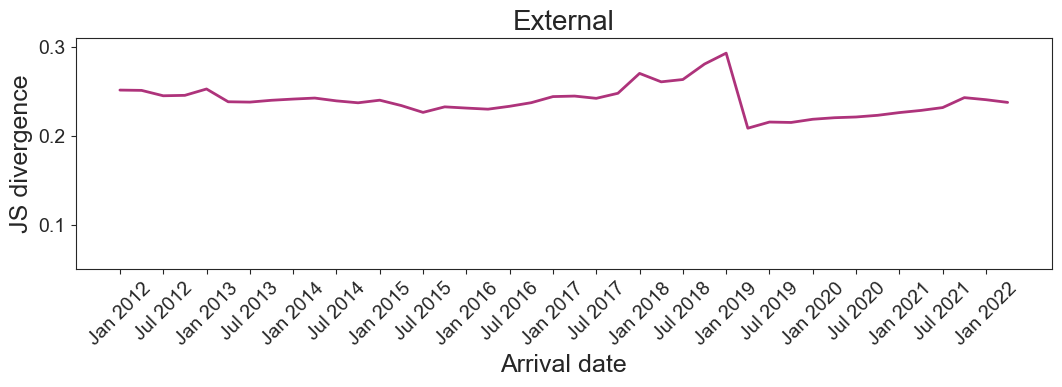

In [16]:
# 7. Distribution of selected features
plot_divergence_over_time(df_dev, df, selected_features, title=dataset_name, palette=palette, results_dir=results_dir)

___
# Archived
___

# Reviewed predicitons

In [ ]:
unseen_data_filename = "lvrh_2012_2022"

df = pd.read_csv("../datasets/" + unseen_data_filename + "_predicted.csv")

# Convert to datetime and extract year and quarter
df.arrival_date = pd.to_datetime(df.arrival_date)
df['year'] = df.arrival_date.dt.year
df['quarter'] = df.arrival_date.dt.to_period('Q')

In [ ]:
df_reviewed = pd.read_csv("../datasets/" + unseen_data_filename + "_reviewed.csv")
df_reviewed.rename(columns={'Revised': 'revised', 
                            'Recoded_SH': 'recoded_SH', 
                            'Recoded_SI': 'recoded_SI',
                            'Recoded_AOD_OD': 'recoded_AOD_OD', 
                            'Comment': 'comment'}, 
                            inplace=True)
df = pd.concat([
    df, df_reviewed[['revised', 'recoded_SH', 'recoded_SI', 'recoded_AOD_OD', 'comment']]
    ], axis=1)

# Remove 2022
df = df[df.year < 2018].copy()

print(df.shape)
df.head(1)

### Reviewed notes

In [ ]:
df.for_review.sum()

In [ ]:
df[df.for_review==1].prediction_class.value_counts()

In [ ]:
df[df.for_review==1].year.value_counts()

In [ ]:
(df[df.for_review==1].quarter.value_counts() == 6).all()

In [ ]:
df.revised.sum()

In [ ]:
df[['recoded_SH', 'recoded_SI', 'recoded_AOD_OD']].sum()

### Revised false-positives (Neg pred Pos -> Pos)
**Self-harm**

In [ ]:
df[(df.prediction_class=='FP') & (df.revised==1)]

In [ ]:
df[(df.prediction_class=='FP') & (df.revised==1)].recoded_SH.sum()

In [ ]:
6/72, 11/120

In [ ]:
df[(df.prediction_class=='FP') & (df.revised==1) & (df.recoded_SH==1)].probability.describe()

**Suicidal ideation**

In [ ]:
df.loc[(df.prediction_class=='FP') & (df.revised==1)].recoded_SI.sum()

### Revised false-negatives (Pos pred Neg -> Neg)

In [ ]:
df[(df.prediction_class=='FN') & (df.revised==1)]

In [ ]:
(df[(df.prediction_class=='FN') & (df.revised==1)].recoded_SH.fillna(0)==0).sum()

In [ ]:
5/72, 12/120

In [ ]:
df.loc[(df.prediction_class=='FN') & (df.revised==1)].probability.describe()

**Plot probability distributions**

In [ ]:
# sns.histplot(x='probability', data=df[df.prediction_class=='TN'], 
#              binwidth=0.035, color=sns.color_palette('Paired')[1], label='TN');
# sns.histplot(x='probability', data=df[df.prediction_class=='FN'], 
#              binwidth=0.035, color=sns.color_palette('Paired')[0], label='FN');
# sns.histplot(x='probability', data=df[df.prediction_class=='TP'], 
#              binwidth=0.035, color=sns.color_palette('Paired')[3], label='TP');
# sns.histplot(x='probability', data=df[df.prediction_class=='FP'], 
#              binwidth=0.035, color=sns.color_palette('Paired')[2], label='FP');


# plt.axvline(thresh, 0, 1, color=sns.color_palette('Paired')[5], ls='--', label='Original\nthreshold');
# # plt.axvline(thresh_adj, 0, 1, color=sns.color_palette('Paired')[9], ls='--', label='Adjusted\nthreshold');
# plt.legend();
# plt.xlim([0,1]);
# plt.ylim([0,2200]);
# plt.xlabel("Predicted probability");
# plt.ylabel("Count");
# # plt.savefig("../results/Adjusted threshold.jpeg", bbox_inches='tight', dpi=300);

In [ ]:
df['review_outcome'] = ""
df.loc[(df.prediction_class=='FP') & (df.for_review==1) & (df.recoded_SH!=1), 'review_outcome'] = "Confirmed FP"
df.loc[(df.prediction_class=='FP') & (df.for_review==1) & (df.revised==1) & (df.recoded_SH==1), 'review_outcome'] = "Revised TP"
df.loc[(df.prediction_class=='FN') & (df.for_review==1) & (df.revised==0), 'review_outcome'] = "Confirmed FN"
df.loc[(df.prediction_class=='FN') & (df.for_review==1) & (df.revised==1), 'review_outcome'] = "Revised TN"
df.review_outcome = df.review_outcome.astype('category').cat.set_categories(["Confirmed FN", "Revised TN", 
                                                                             "Confirmed FP", "Revised TP"])
df.review_outcome.value_counts().sort_index()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6)

thresh = 0.36

sns.histplot(x='probability', data=df[df.review_outcome=='Confirmed FN'], 
             binwidth=0.035, binrange=(0,thresh), color=sns.color_palette('Paired')[0], label='Confirmed FN');
sns.histplot(x='probability', data=df[df.review_outcome=='Revised TN'], 
             binwidth=0.035, binrange=(0,thresh), color=sns.color_palette('Paired')[1], label='Revised TN');
sns.histplot(x='probability', data=df[df.review_outcome=='Confirmed FP'], 
             binwidth=0.035, binrange=(thresh,1), color=sns.color_palette('Paired')[2], label='Confirmed FP');
sns.histplot(x='probability', data=df[df.review_outcome=='Revised TP'], 
             binwidth=0.035, binrange=(thresh,1), color=sns.color_palette('Paired')[3], label='Revised TP');

plt.legend();
plt.xlim([0,1]);
plt.xlabel("Predicted probability");
plt.ylabel("Count");
plt.savefig("../results/Review results.jpeg", bbox_inches='tight', dpi=300);

In [ ]:
# Evaluate classification
evaluate_classification(df.SH, df.prediction, filename=None)

In [ ]:
counts = df.prediction_class.value_counts()
counts

In [ ]:
# PPV
fp2tp = counts.FP * 6/72
print("%d notes will be reviewed as true positive" % fp2tp)
(counts.TP + fp2tp) / (counts.TP + counts.FP)

In [ ]:
# Sensitivity
fn2tn = counts.FN * 5/72
print("%d notes will be reviewed as true negative" % fn2tn)
(counts.TP + fp2tp) / (counts.TP + fp2tp + counts.FN - fn2tn)

In [ ]:
# Specificity
(counts.TN + fn2tn) / (counts.TN + counts.FN)

In [ ]:
83 - (83-57)/2

In [ ]:
data_filename = "rmh_2012_2017_dev"
# Load selected features
with open(models_dir / (data_filename + "_selected_fts.txt"), 'r') as f:
    selected_features_rmh = f.read().split()
len(selected_features_rmh)

data_filename = "lvrh_2012_2022"
# Load selected features
with open(models_dir / (data_filename + "_selected_fts.txt"), 'r') as f:
    selected_features_lvrh = f.read().split()
len(selected_features_lvrh)

selected_features_rmh

selected_features_lvrh

set(selected_features_rmh) - set(selected_features_lvrh)